# 1.Training and validation - Decision Tree NBA Dataset

In [1]:
# Librerias base
library(caret) # Libreria de Machine learning
library(Matrix) # Libreria para componer eleentos matriciales
library(rpart) # Libreria para generar el decision tree
library(e1071)

# Librerias para visualizar el decision tree
library(rattle)
library(rpart.plot)
library(RColorBrewer)

Loading required package: lattice

Loading required package: ggplot2

Rattle: A free graphical interface for data science with R.
Versión 5.3.0 Copyright (c) 2006-2018 Togaware Pty Ltd.
Escriba 'rattle()' para agitar, sacudir y  rotar sus datos.



Cargamos el raw dataset

In [2]:
raw_data = read.csv('nba_logreg.csv', sep = ',')
head(raw_data)

,Name,GP,MIN,PTS,FGM,FGA,FG.,X3P.Made,X3PA,X3P.,...,FTA,FT.,OREB,DREB,REB,AST,STL,BLK,TOV,class
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
2,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
3,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
4,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
5,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1
6,Tony Bennett,75,11.4,3.7,1.5,3.5,42.3,0.3,1.1,32.5,...,0.5,73.2,0.2,0.7,0.8,1.8,0.4,0.0,0.7,0


In [3]:
# En este caso retiramos la variable de median_value pues buscamos clasificar 
median_value = c(1)
raw_data_no_value = raw_data[,-median_value]
raw_data_no_value = raw_data_no_value[complete.cases(raw_data_no_value), ]
head(raw_data_no_value)

,GP,MIN,PTS,FGM,FGA,FG.,X3P.Made,X3PA,X3P.,FTM,FTA,FT.,OREB,DREB,REB,AST,STL,BLK,TOV,class
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
2,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
3,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
4,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
5,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1
6,75,11.4,3.7,1.5,3.5,42.3,0.3,1.1,32.5,0.4,0.5,73.2,0.2,0.7,0.8,1.8,0.4,0.0,0.7,0


In [4]:
# Generamos 2 datasets para nuestro modelo
set.seed(123)

# Percentages
fractionTraining   <- 0.80
fractionValidation <- 0.20

# Compute sample sizes.
sampleSizeTraining   <- floor(fractionTraining   * nrow(raw_data_no_value))
sampleSizeValidation <- floor(fractionValidation * nrow(raw_data_no_value))

# Create the randomly-sampled indices for the dataframe. Use setdiff() to
# avoid overlapping subsets of indices.
indicesTraining    <- sort(sample(seq_len(nrow(raw_data_no_value)), size=sampleSizeTraining))
indicesNotTraining <- setdiff(seq_len(nrow(raw_data_no_value)), indicesTraining)
indicesValidation  <- sort(sample(indicesNotTraining, size=sampleSizeValidation))

# Finally, output the three dataframes for training, validation and test.
dfTraining   <- raw_data_no_value[indicesTraining, ]
dfValidation <- raw_data_no_value[indicesValidation, ]

In [5]:
head(dfValidation)
head(dfTraining)

,GP,MIN,PTS,FGM,FGA,FG.,X3P.Made,X3PA,X3P.,FTM,FTA,FT.,OREB,DREB,REB,AST,STL,BLK,TOV,class
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
14,45,15.3,5.6,1.9,6.0,32.3,1.1,3.6,30.1,0.7,0.8,86.1,0.5,1.6,2.0,0.5,0.5,0.3,0.5,0
15,44,6.4,2.4,1.0,1.9,53.7,0.0,0.0,0.0,0.4,0.7,50.0,0.4,1.0,1.4,0.2,0.2,0.4,0.6,1
21,80,31.4,14.3,5.9,11.1,52.5,0.0,0.1,11.1,2.6,3.9,65.4,3.0,5.0,8.0,2.4,1.1,0.8,2.2,1
22,82,30.5,13.3,5.4,11.0,48.9,0.0,0.1,16.7,2.6,3.9,66.6,2.3,2.8,5.1,2.5,1.5,0.3,2.2,1
33,82,19.6,7.4,3.1,7.3,41.9,0.0,0.3,4.3,1.2,1.5,80.6,0.6,1.4,2.0,3.9,1.0,0.3,1.7,1
43,51,14.5,5.0,1.5,3.8,39.9,0.2,0.7,27.0,1.8,2.0,87.5,0.4,1.2,1.5,2.8,0.9,0.0,1.4,0


,GP,MIN,PTS,FGM,FGA,FG.,X3P.Made,X3PA,X3P.,FTM,FTA,FT.,OREB,DREB,REB,AST,STL,BLK,TOV,class
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
2,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
3,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
4,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
5,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1
6,75,11.4,3.7,1.5,3.5,42.3,0.3,1.1,32.5,0.4,0.5,73.2,0.2,0.7,0.8,1.8,0.4,0.0,0.7,0


## Modelo

In [6]:
# Establecemos la variable target y establecemos el tipo de dato como label
target <- c(20)
class_label <- dfTraining[,target]

In [7]:
##Generamos una entrada de control features
control_features <- rpart.control(xval = 10 #Cross validation del dataset
                                  , maxdepth = c(4,6,8,10,12)) #Vector con iteraciones máximas para el clasificador

Warning message in if (maxdepth > 30L) stop("Maximum depth is 30"):
"la condición tiene longitud > 1 y sólo el primer elemento será usado"
Warning message in if (maxdepth < 1L) stop("Maximum depth must be at least 1"):
"la condición tiene longitud > 1 y sólo el primer elemento será usado"


In [8]:
## Función del decision tree

In [9]:
## Función del decision tree
decision_tree <- rpart(class ~ .
                       , data=dfTraining
                       , method="class"
                       , control = control_features)

#Descripcion de la estructura de la funcion
print(decision_tree)

n= 1063 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 1063 411 1 (0.3866416 0.6133584)  
   2) GP< 58.5 462 194 0 (0.5800866 0.4199134)  
     4) OREB< 0.65 261  85 0 (0.6743295 0.3256705) *
     5) OREB>=0.65 201  92 1 (0.4577114 0.5422886)  
      10) FTM< 0.85 107  47 0 (0.5607477 0.4392523)  
        20) MIN>=6.95 96  38 0 (0.6041667 0.3958333) *
        21) MIN< 6.95 11   2 1 (0.1818182 0.8181818) *
      11) FTM>=0.85 94  32 1 (0.3404255 0.6595745) *
   3) GP>=58.5 601 143 1 (0.2379368 0.7620632) *


In [10]:
predicted_values <- predict(decision_tree, dfTraining, type = "class")
prediction_df <- data.frame(reference = dfTraining$class, prediction = predicted_values)

In [11]:
confusion_values_dtrees <- confusionMatrix(prediction_df$prediction, reference = as.factor(prediction_df$reference))
confusion_values_dtrees

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 234 123
         1 177 529
                                          
               Accuracy : 0.7178          
                 95% CI : (0.6897, 0.7447)
    No Information Rate : 0.6134          
    P-Value [Acc > NIR] : 5.935e-13       
                                          
                  Kappa : 0.3902          
                                          
 Mcnemar's Test P-Value : 0.002214        
                                          
            Sensitivity : 0.5693          
            Specificity : 0.8113          
         Pos Pred Value : 0.6555          
         Neg Pred Value : 0.7493          
             Prevalence : 0.3866          
         Detection Rate : 0.2201          
   Detection Prevalence : 0.3358          
      Balanced Accuracy : 0.6903          
                                          
       'Positive' Class : 0               
                              

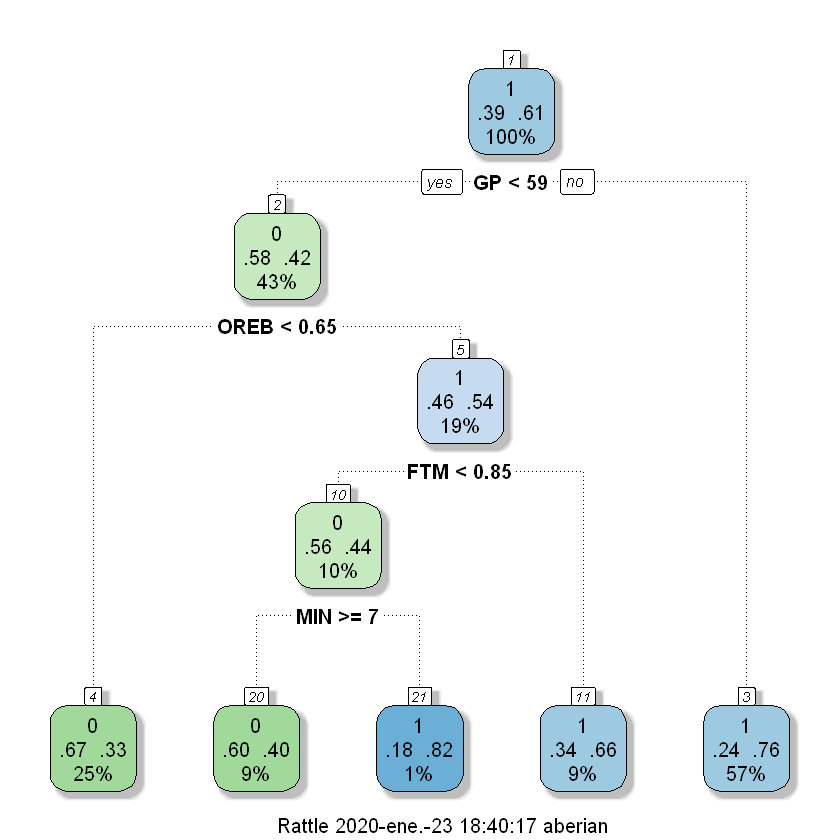

In [12]:
##Representacion grafica del decision tree
fancyRpartPlot(decision_tree)

In [13]:
predicted_values_test <- predict(decision_tree, dfValidation, type = "class")
prediction_df_test <- data.frame(reference = dfValidation$class, prediction = predicted_values_test)
confusion_values_dtrees <- confusionMatrix(prediction_df_test$prediction, reference = as.factor(prediction_df_test$reference))
confusion_values_dtrees

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  51  37
         1  40 137
                                          
               Accuracy : 0.7094          
                 95% CI : (0.6507, 0.7634)
    No Information Rate : 0.6566          
    P-Value [Acc > NIR] : 0.03903         
                                          
                  Kappa : 0.3506          
                                          
 Mcnemar's Test P-Value : 0.81971         
                                          
            Sensitivity : 0.5604          
            Specificity : 0.7874          
         Pos Pred Value : 0.5795          
         Neg Pred Value : 0.7740          
             Prevalence : 0.3434          
         Detection Rate : 0.1925          
   Detection Prevalence : 0.3321          
      Balanced Accuracy : 0.6739          
                                          
       'Positive' Class : 0               
                              